Found 1828 images belonging to 8 classes.
Found 457 images belonging to 8 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training the top layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 903s 15s/step - accuracy: 0.2348 - loss: 2.3938 - val_accuracy: 0.1816 - val_loss: 2.1278 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 852ms/step - accuracy: 0.4385 - loss: 1.5933 - val_accuracy: 0.2035 - val_loss: 2.1608 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 866ms/step - accuracy: 0.4664 - loss: 1.5159 - val_accuracy: 0.1794 - val_loss: 2.1705 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 854ms/step - accuracy: 0.5387 - loss: 1.2984 - val_accuracy: 0.1816 - val_loss: 2.2064 - learning_rate: 1.0000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 843ms/step - accuracy: 0.5426 - loss: 1.3080 - val_accuracy: 0.1882 - val_loss: 2.5099 - learning_rate: 1.0000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 844ms/step - accuracy: 0.5592 - loss: 1.2133 - val_accuracy: 0.2232 - val_loss: 2.2050 - learning_rate: 1.0000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 875ms/step - accu

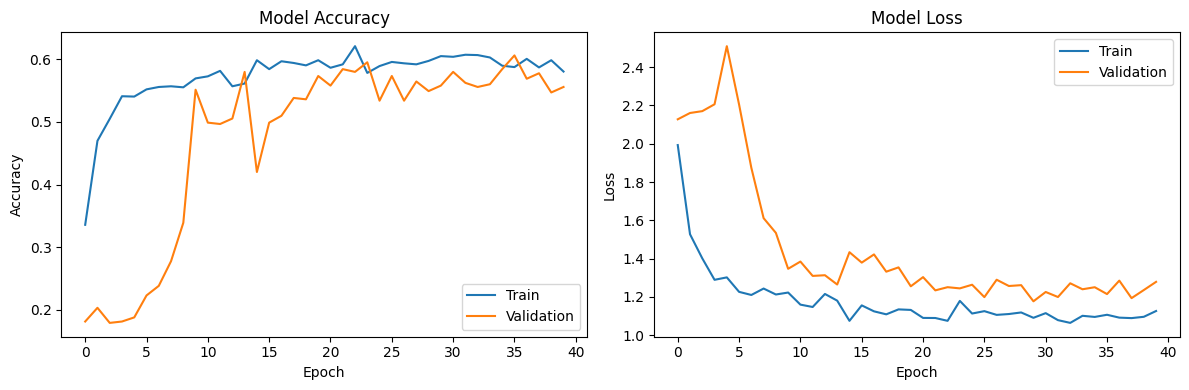

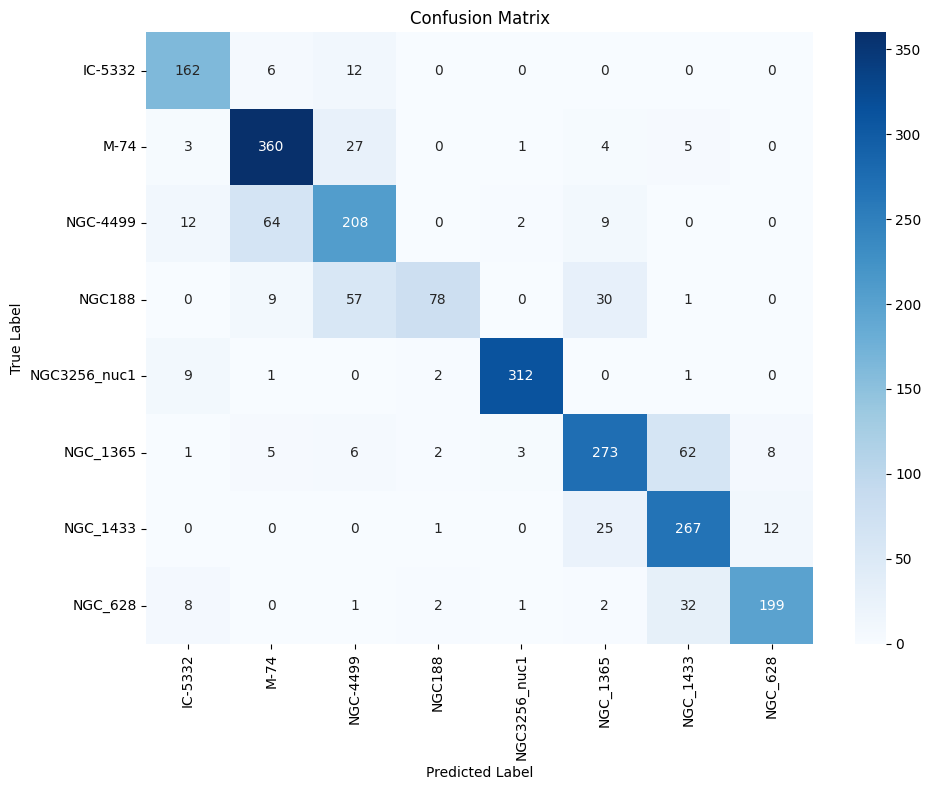

In [3]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
import tensorflow as tf

# Configuration
IMG_SIZE = 224  # ResNet50 default input size
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

def create_model(num_classes):
    """Create ResNet50-based model with fine-tuning"""

    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)  # Normalize activations
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with improved augmentation."""

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,   # Increased zoom range
        brightness_range=[0.8, 1.2],  # Improve generalization
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def plot_training_history(history):
    """Plot training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Set up data paths
    data_dir = '/content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset'  # Change to your dataset path

    # Set up data generators
    train_datagen, test_datagen = setup_data_generators()

    # Load and prepare the data
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Get number of classes
    num_classes = len(train_generator.class_indices)

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Set up callbacks
    callbacks = [
        ModelCheckpoint(
            '/content/drive/MyDrive/Ml-project/Project-Review-3/top_mod.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    # Train the model
    print("Training the top layers...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    # Fine-tune the model
    print("Fine-tuning the model...")

    # Unfreeze more layers for fine-tuning
    for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
        layer.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history_fine = model.fit(
        train_generator,
        epochs=EPOCHS//2,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    # Evaluate the model
    print("Evaluating the model...")
    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Print classification report
    class_names = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot training history and confusion matrix
    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
